In [1]:
from gensim.models import word2vec
import MeCab
import numpy as np
import json
import hashlib
from sklearn.cross_decomposition import CCA
from googletrans import Translator
import numpy as np
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import torch
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
%matplotlib inline

In [2]:
translator = Translator()
mt = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
mt.parse('')
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

In [3]:
model_doc = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")
model_word = word2vec.Word2Vec.load("wiki_plus.model")
model_bert = BertModel.from_pretrained('bert-base-japanese-whole-word-masking')

In [4]:
def get_tags(text):
    word = {}
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if (fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞') and node.surface in model_word.wv:
            w = node.surface
            word[w] = word.get(w, 0) + 1
        node = node.next
    return word

def weighted_mean_vec(text):
    v = np.zeros(model_word.vector_size)
    s = 1.0
    for w,weight in get_tags(text).items():
        v += weight * model_word.wv[w]  #Eventクラスeの単語wの個数＊単語wのベクトル
        s += weight
    return v / s

In [5]:
def get_tags_for_doc2vec(text):
    word = []
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if node.surface in model_doc.wv and node.surface !='':
            w = node.surface
            word.append(w)
        node = node.next
    return word

In [6]:
#bertのベクトル化
def get_vector_cls(text):
    input_ids = tokenizer.encode(text, return_tensors='pt') 
    result = model_bert(input_ids)
    tensor_result = result[0][0][0]
    numpy_result = tensor_result.to('cpu').detach().numpy().copy()
    return numpy_result

In [7]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.links = links

In [8]:
# JSON ファイルから event set をロード
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [9]:
events = load_events('sesaku2.json')

In [10]:
import pandas as pd
data = []
labels = []
columns=[]
index=[]
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        index.append(v1.desc)
for k1, v1 in events.items():
    if v1.type[-1]=='対策':
        if not v1.desc in columns:
            columns.append(v1.desc)
df = pd.DataFrame(index=index, columns=columns)
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events.items():
            if v2.type[-1] == '対策':
                    if v2 in v1.links:
                        df.at[v1.desc, v2.desc] = 1
                    else:
                        df.at[v1.desc, v2.desc] = 0
df

,前機種の振り返りを実施。目標に対する達成度、課題と次の一手を適用している,会社方針と中・長期計画を基に、商品企画と製品企画を経て、目標を設定している。,社会との調和、社会への貢献実現のビジョンがある,経営責任を明確化,的確な経営判断が９０％の迅速さで下されている,社長を補佐できるキーパーソンが各部門に存在,方針管理は部門別と機能別を組み合わせたマトリックスマネジメントで管理,日常管理が各機能ごとに項目と目標が明確で、管理責任者も設定,管理目標から外れた場合のアクションが取られている,QCDの視点で、目標を設定。関連部品にも目標展開、仕様を決めた後、全体目標をアラインしている。,...,異常有無を全数検査している（外観・異音・振動等）,プランジャ当たり面の検査は、定量化・仕組み化・標準化しているか,インジェクターの色識別（品番との合致）,噴射レベルの抜き取り検査,エンジン性能の検査（トヨタ）,"機能テストは、設計指示の環境条件を満足しているか (燃料,温度,気圧 等)",インジェクターをエンジンに挿入する時の抵抗測定をする,バリ、異物有無を検査している（画像検査等）,機能検査を実施している（電流ｘ噴射量）,リーク検査を実施しているる
エンジン搭載 吸気レゾネーター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗器アセンブリ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 ゴム クッション,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料圧力ダンパー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗カバー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料フィルター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料パイプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料蒸気供給ホース,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ホース クランプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
taisaku_vec_word = {}
for i in df:
    taisaku_vec_word[i]=weighted_mean_vec(i)

In [12]:
taisaku_vec_doc = {}
for i in df:
    taisaku_vec_doc[i]=model_doc.infer_vector(get_tags_for_doc2vec(i))

In [13]:
taisaku_vec_bert = {}
for i in df:
    taisaku_vec_bert[i]=get_vector_cls(i)

In [14]:
class Label:
    TAISAKU = 1
    NASI = 0

data_word = []
labels_word = []
# data 
for index, row in df.iterrows():#部品
    x1 = weighted_mean_vec(index)
    for i in df:#対策
        x2 =  taisaku_vec_word[i]#対策
        data_word.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_word.append(Label.TAISAKU)
        else:
            labels_word.append(Label.NASI)

In [15]:
data_doc = []
labels_doc = []
# data 
for index, row in df.iterrows():#部品
    x1 = model_doc.infer_vector(get_tags_for_doc2vec(index))
    for i in df:#対策
        x2 =  taisaku_vec_doc[i]#対策
        data_doc.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_doc.append(Label.TAISAKU)
        else:
            labels_doc.append(Label.NASI)

In [16]:
data_BERT_cls = []
labels_BERT_cls = []
# data 
for index, row in df.iterrows():#部品
    x1 = get_vector_cls(index) #部品
    for i in df:#対策
        x2=taisaku_vec_bert[i]
        data_BERT_cls.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_BERT_cls.append(Label.TAISAKU)
        else:
            labels_BERT_cls.append(Label.NASI)

In [17]:
def train_data(data,labels):
    index_1 = [i for i, x in enumerate(labels) if x == 1]
    index_0 = [i for i, x in enumerate(labels) if x == 0]
    index_0 = random.sample(index_0, len(index_1))
    data_1 = [data[i] for i in index_1]
    data_0 = [data[i] for i in index_0]
    labels = [Label.TAISAKU]*len(data_1) + [Label.NASI]*len(data_0) 
    data = data_1 + data_0
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [18]:
len(data_doc[1])

600

In [19]:
len(data_word[1])

400

In [20]:
len(data_BERT_cls[1])

1536

In [21]:
def gakusyu(data,labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    print('トレーニングデータの1の数    :',y_train.sum())
    print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
    print('テストデータの１の数            :',y_test.sum())
    print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')
    # y_train を one-hot 表現にする。
    y_train_one_hot = np_utils.to_categorical(y_train)
    y_test_one_hot = np_utils.to_categorical(y_test)
    # モデルを作成する。
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=x_train.shape[1:])) #activation
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.001), #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
        loss='categorical_crossentropy', #損失関数名
        metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

    # 学習を実行する。
    result = model.fit(x_train, y_train_one_hot , batch_size=16, epochs=30,validation_data=(x_test, y_test_one_hot ),verbose=0) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

    # 推論する。
    prob = model.predict(x_test, batch_size=len(x_test))

    # 最も確率が高いのを推定クラスとする。
    y_pred = np.argmax(prob, axis=1)

    # 精度を検証する。
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))
    return result, accuracy, model, x_test, y_test_one_hot

# PCA

In [22]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import scipy.stats

In [23]:
def principal_component_analysis(data,kiyoritu):
    dfs = scipy.stats.zscore(data)
    dfs_stand = pd.DataFrame(dfs, columns=["".format(x+1) for x in range(len(dfs[1]))])
    #主成分分析の実行
    pca = PCA()
    pca.fit(dfs_stand)
    # データを主成分空間に写像
    feature = pca.transform(dfs_stand)
    print(pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(dfs_stand.columns))]).head())
    a = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(dfs_stand.columns))])
    kiyo = kiyoritu
    total = 0
    count = 0
    for index, row in a.iterrows():
        total += row[0]
        count +=1
        if(kiyo < total):
            break
    print('寄与率: '+ str(kiyo) +'を超えるための成分数:'+str(count))

In [24]:
principal_component_analysis(data_word,0.99)

            0
PC1  0.107849
PC2  0.049872
PC3  0.048454
PC4  0.044100
PC5  0.033280
寄与率: 0.99を超えるための成分数:206


In [25]:
principal_component_analysis(data_doc,0.99)

            0
PC1  0.059803
PC2  0.041730
PC3  0.030468
PC4  0.025616
PC5  0.024389
寄与率: 0.99を超えるための成分数:340


In [26]:
principal_component_analysis(data_BERT_cls,0.99)

            0
PC1  0.049620
PC2  0.045266
PC3  0.040158
PC4  0.032302
PC5  0.025871
寄与率: 0.99を超えるための成分数:377


In [27]:
def pca_accuracy(n, data, labels):
    pca = PCA(n_components=n)
    pca.fit(data)
    data_pca = pca.transform(data)
    history = {'data_pca':0,'count':0}
    data_result = []
    for i in range(3):
        data_2, labels_2= train_data(data_pca,labels)
        result, accuracy, model, x_test, y_test = gakusyu(data_2, labels_2)
        history['data_pca'] = history['data_pca'] + accuracy
        history['count'] += 1
        data_result.append(result)
    result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
    for k,v in result_all.items():
        for i in range(30):
            for j in data_result:
                v[i] += j.history[k][i]
            v[i] /= 3
    return result_all

def accuracy_plt(result):
    plt.plot(range(1, 30+1),result['accuracy'] , label="training")
    plt.plot(range(1, 30+1), result['val_accuracy'], label="validation")
    plt.xlabel('学習回数')
    plt.ylabel('正解率')
    plt.legend()
    plt.show()

In [28]:
result_word = pca_accuracy(206,data_word,labels_word)
result_doc= pca_accuracy(340,data_doc,labels_doc)
result_bert = pca_accuracy(377,data_BERT_cls, labels_BERT_cls)

トレーニングデータの1の数    : 5840
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1463
テストデータの1の割合          : 50.1 %
accuracy: 97.98%
トレーニングデータの1の数    : 5804
トレーニングデータ1の割合    : 49.7 %
テストデータの１の数            : 1499
テストデータの1の割合          : 51.3 %
accuracy: 97.84%
トレーニングデータの1の数    : 5819
トレーニングデータ1の割合    : 49.8 %
テストデータの１の数            : 1484
テストデータの1の割合          : 50.8 %
accuracy: 98.43%
トレーニングデータの1の数    : 5853
トレーニングデータ1の割合    : 50.1 %
テストデータの１の数            : 1450
テストデータの1の割合          : 49.6 %
accuracy: 99.45%
トレーニングデータの1の数    : 5807
トレーニングデータ1の割合    : 49.7 %
テストデータの１の数            : 1496
テストデータの1の割合          : 51.2 %
accuracy: 99.73%
トレーニングデータの1の数    : 5837
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1466
テストデータの1の割合          : 50.2 %
accuracy: 99.69%
トレーニングデータの1の数    : 5825
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 1478
テストデータの1の割合          : 50.6 %
accuracy: 97.78%
トレーニングデータの1の数    : 5876
トレーニングデータ1の割合    : 50.3 %
テストデータの１の数            : 1427
テストデータの1の割合          : 48.8 %
accuracy:

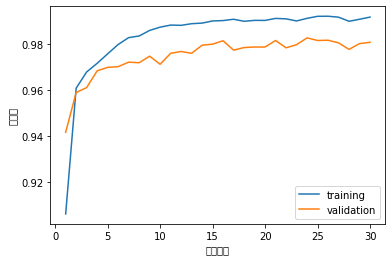

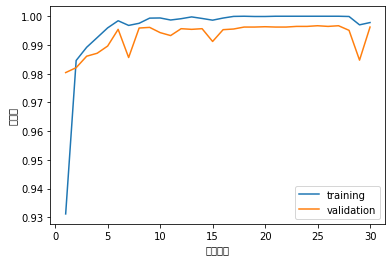

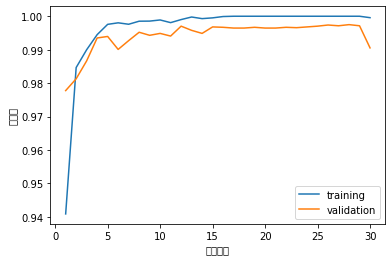

In [30]:
accuracy_plt(result_word)
accuracy_plt(result_doc)
accuracy_plt(result_bert)

#  クラスタリング

In [70]:
from matplotlib import pyplot as plt
from sklearn import datasets, preprocessing
from sklearn.cluster import KMeans
import numpy as np 
import pandas as pd
pred = KMeans(n_clusters=5).fit_predict(data_word)
pred

array([3, 3, 3, ..., 2, 2, 2], dtype=int32)

In [71]:
clustering_data = {0:[], 1:[], 2:[],3:[],4:[]}
clustering_label = {0:[],1:[],2:[],3:[],4:[]}
for i, x in enumerate(pred):
    clustering_data[x].append(data_word[i])
    clustering_label[x].append(labels_word[i])

In [66]:
data_word2, labels_word2= train_data(data_word,labels_word)
result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)

トレーニングデータの1の数    : 5818
トレーニングデータ1の割合    : 49.8 %
テストデータの１の数            : 1485
テストデータの1の割合          : 50.8 %
accuracy: 98.29%


In [67]:
def clustering_accuracy(data,label):
    data_word2,labels_word2 =  np.array(data),np.array(label)
    #data_word_one_hot = np_utils.to_categorical(data_word2)
    prob = model.predict(data_word2, batch_size=len(data_word2))
    y_pred = np.argmax(prob, axis=1)
    # 精度を検証する。
    accuracy = accuracy_score(labels_word2, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))

In [68]:
clustering_accuracy(clustering_data[0] ,clustering_label[0])
clustering_accuracy(clustering_data[1] ,clustering_label[1])
clustering_accuracy(clustering_data[2] ,clustering_label[2])
clustering_accuracy(clustering_data[3] ,clustering_label[3])
clustering_accuracy(clustering_data[4] ,clustering_label[4])

accuracy: 98.70%
accuracy: 98.09%
accuracy: 99.12%
accuracy: 98.46%
accuracy: 97.49%
